In [1]:
# import sys
# sys.path.append("../../semi-supervised")
# from functools import reduce
# from operator import __or__
# from torch.utils.data.sampler import SubsetRandomSampler
# from torchvision.datasets import MNIST
# import torchvision.transforms as transforms
# from utils import onehot
# 
# location = "./"
# n_labels = 10
# 
# mnist_train = MNIST(location, train=True, download=True)
# numpy_mnist = mnist_train.data.numpy().reshape(-1, 784) / 255
# mnist_mean = numpy_mnist.mean(0)
# mnist_std = numpy_mnist.std(0)
# 
# mnist_indices = np.where(mnist_std > 0.1)
# 
# 
# 
# flatten_bernoulli = lambda x: transforms.ToTensor()(x).view(-1)[mnist_indices].bernoulli()
# 
# mnist_train = MNIST(location, train=True, download=True,
#                     transform=flatten_bernoulli, target_transform=onehot(n_labels))
# mnist_valid = MNIST(location, train=False, download=True,
#                     transform=flatten_bernoulli, target_transform=onehot(n_labels))
# 

In [2]:
# Imports
import torch
cuda = torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../../semi-supervised")

torch.multiprocessing.set_sharing_strategy('file_system')


# Auxiliary Deep Generative Model

The Auxiliary Deep Generative Model [[Maaløe, 2016]](https://arxiv.org/abs/1602.05473) posits a model that with an auxiliary latent variable $a$ that infers the variables $z$ and $y$. This helps in terms of semi-supervised learning by delegating causality to their respective variables. This model was state-of-the-art in semi-supervised until 2017, and is still very powerful with an MNIST accuracy of *99.4%* using just 10 labelled examples per class.

<img src="../images/adgm.png" width="400px"/>


In [3]:
from models import AuxiliaryDeepGenerativeModel

y_dim = 10
# z_dim = 300
# a_dim = 300
x_dim = 784
z_dim = 100
a_dim = 100
h_dim = [500, 500]
# h_dim = [1000, 1000]

# TODO: trzeba zrobić redukcje wymiarowości przez std < 0.1
# model = AuxiliaryDeepGenerativeModel([3072, y_dim, z_dim, a_dim, h_dim])
model = AuxiliaryDeepGenerativeModel([x_dim, y_dim, z_dim, a_dim, h_dim], batch_norm=False)
model

784
Linear layers in classifier [ReLU(), BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Linear(in_features=500, out_features=500, bias=True), ReLU(), BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
[784, 100]
Linear layers in classifier [ReLU(), Linear(in_features=500, out_features=500, bias=True), ReLU()]


../../semi-supervised/models/vae.py:235: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)
../../semi-supervised/models/dgm.py:109: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


AuxiliaryDeepGenerativeModel(
  (encoder): Encoder(
    (first_dense): ModuleList(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): Linear(in_features=10, out_features=500, bias=True)
      (2): Linear(in_features=100, out_features=500, bias=True)
    )
    (hidden): ModuleList(
      (0): ReLU()
      (1): Linear(in_features=500, out_features=500, bias=True)
      (2): ReLU()
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=500, out_features=100, bias=True)
      (log_var): Linear(in_features=500, out_features=100, bias=True)
    )
  )
  (decoder): Decoder(
    (first_dense): ModuleList(
      (0): Linear(in_features=100, out_features=500, bias=True)
      (1): Linear(in_features=10, out_features=500, bias=True)
    )
    (hidden): ModuleList(
      (0): ReLU()
      (1): Linear(in_features=500, out_features=500, bias=True)
      (2): ReLU()
    )
    (reconstruction): Linear(in_features=500, out_features=784, bias=True)
  )
  (classifier): 

## Training

The lower bound we derived in the notebook for the **deep generative model** is similar to the one for the ADGM. Here, we also need to integrate over a continuous auxiliary variable $a$.

For labelled data, the lower bound is given by.
\begin{align}
\log p(x,y) &= \log \int \int p(x, y, a, z) \ dz \ da\\
&\geq \mathbb{E}_{q(a,z|x,y)} \bigg [\log \frac{p(x,y,a,z)}{q(a,z|x,y)} \bigg ] = - \mathcal{L}(x,y)
\end{align}

Again when no label information is available we sum out all of the labels.

\begin{align}
\log p(x) &= \log \int \sum_{y} \int p(x, y, a, z) \ dz \ da\\
&\geq \mathbb{E}_{q(a,y,z|x)} \bigg [\log \frac{p(x,y,a,z)}{q(a,y,z |x)} \bigg ] = - \mathcal{U}(x)
\end{align}

Where we decompose the q-distribution into its constituent parts. $q(a, y, z|x) = q(z|a,y,x)q(y|a,x)q(a|x)$, which is also what can be seen in the figure.

The distribution over $a$ is similar to $z$ in the sense that it is also a diagonal Gaussian distribution. However by introducing the auxiliary variable we allow for $z$ to become arbitrarily complex - something we can also see when using normalizing flows.

In [4]:
from datautils import get_mnist, get_svhn

# Only use 10 labelled examples per class
# The rest of the data is unlabelled.
labelled, unlabelled, validation, mnist_mean, mnist_std = get_mnist(location="./", batch_size=100, labels_per_class=10, preprocess=False)
# labelled, unlabelled, validation = get_svhn(location="./", batch_size=1000, labels_per_class=100)

alpha = .1 * (len(unlabelled) + len(labelled)) / len(labelled)

def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

def mse(r, x):
    return torch.sum(torch.pow(x - r, 2), dim=-1)


optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999), weight_decay=0.5 / 60000)

In [5]:
from itertools import cycle
from inference import SVI, DeterministicWarmup, ImportanceWeightedSampler

# We will need to use warm-up in order to achieve good performance.
# Over 200 calls to SVI we change the autoencoder from
# deterministic to stochastic.
# beta = DeterministicWarmup(n=0)
iw_sampler = ImportanceWeightedSampler(mc=10, iw=1)


if cuda: model = model.cuda()
elbo = SVI(model, likelihood=binary_cross_entropy, sampler=iw_sampler)



The library is conventially packed with the `SVI` method that does all of the work of calculating the lower bound for both labelled and unlabelled data depending on whether the label is given. It also manages to perform the enumeration of all the labels.

Remember that the labels have to be in a *one-hot encoded* format in order to work with SVI.

In [ ]:
from torch.autograd import Variable
from torch.nn.utils.clip_grad import clip_grad_value_, clip_grad_norm_

from tqdm import tnrange


for epoch in tnrange(200):
    model.train()
    total_loss, accuracy = (0, 0)
    for (x, y), (u, _) in zip(cycle(labelled), unlabelled):
        # Wrap in variables
        x, y, u = Variable(x), Variable(y), Variable(u)

        if cuda:
            # They need to be on the same device and be synchronized.
            x, y = x.cuda(device=0), y.cuda(device=0)
            u = u.cuda(device=0)

        L = -elbo(x, y)
        U = -elbo(u)

        # Add auxiliary classification loss q(y|x)
        # Resample (Monte Carlo)
        x = x.repeat(10, 1)
        logits = model.classify(x)
        
        # Regular cross entropy
        classication_loss = torch.sum(y.repeat(10, 1) * torch.log(logits + 1e-8), dim=1).mean()

        J_alpha = L - alpha * classication_loss + U

        J_alpha.backward()
        clip_grad_norm_(model.parameters(), 5.)
        clip_grad_value_(model.parameters(), 1.)
        
        
        optimizer.step()
        optimizer.zero_grad()

        logits = logits.reshape(10, -1, logits.shape[-1]).mean(0)
        total_loss += J_alpha.item()
        accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())
        
    if epoch % 1 == 0:
        model.eval()
        m = len(unlabelled)
        print("Epoch: {}".format(epoch))
        print("[Train]\t\t J_a: {:.4f}, accuracy: {:.4f}".format(total_loss / m, accuracy / m))

        total_loss, accuracy = (0, 0)
        for x, y in validation:
            x, y = Variable(x), Variable(y)

            if cuda:
                x, y = x.cuda(device=0), y.cuda(device=0)

            L = -elbo(x, y)
            U = -elbo(x)

            # More samples for better estimation
            x = x.repeat(100, 1)
            logits = model.classify(x)
            logits = logits.reshape(100, -1, logits.shape[-1]).mean(0)
            
            classication_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

            J_alpha = L + alpha * classication_loss + U

            total_loss += J_alpha.item()

            _, pred_idx = torch.max(logits, 1)
            _, lab_idx = torch.max(y, 1)
            accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

        m = len(validation)
        print("[Validation]\t J_a: {:.4f}, accuracy: {:.4f}".format(total_loss / m, accuracy / m))

Epoch: 0
[Train]		 J_a: 151.7027, accuracy: 1.0000
[Validation]	 J_a: 222.6957, accuracy: 0.9590
Epoch: 1
[Train]		 J_a: 151.7133, accuracy: 1.0000
[Validation]	 J_a: 223.7742, accuracy: 0.9569
Epoch: 2
[Train]		 J_a: 151.6758, accuracy: 1.0000
[Validation]	 J_a: 222.8517, accuracy: 0.9570
Epoch: 3
[Train]		 J_a: 151.6319, accuracy: 1.0000
[Validation]	 J_a: 223.0100, accuracy: 0.9570
Epoch: 4
[Train]		 J_a: 151.6358, accuracy: 1.0000
[Validation]	 J_a: 222.0492, accuracy: 0.9595
Epoch: 5
[Train]		 J_a: 151.5883, accuracy: 1.0000
[Validation]	 J_a: 221.9404, accuracy: 0.9582
Epoch: 6
[Train]		 J_a: 151.5652, accuracy: 1.0000
[Validation]	 J_a: 222.9305, accuracy: 0.9581
Epoch: 7
[Train]		 J_a: 151.5447, accuracy: 1.0000
[Validation]	 J_a: 223.4360, accuracy: 0.9584
Epoch: 8
[Train]		 J_a: 151.5105, accuracy: 1.0000
[Validation]	 J_a: 222.2425, accuracy: 0.9580
Epoch: 9
[Train]		 J_a: 151.5308, accuracy: 1.0000
[Validation]	 J_a: 221.9546, accuracy: 0.9596
Epoch: 10
[Train]		 J_a: 151.4

Epoch: 84
[Train]		 J_a: 150.4447, accuracy: 1.0000
[Validation]	 J_a: 223.5260, accuracy: 0.9580
Epoch: 85
[Train]		 J_a: 150.4106, accuracy: 1.0000
[Validation]	 J_a: 220.4818, accuracy: 0.9614
Epoch: 86
[Train]		 J_a: 150.3769, accuracy: 1.0000
[Validation]	 J_a: 221.5065, accuracy: 0.9603
Epoch: 87
[Train]		 J_a: 150.3329, accuracy: 1.0000
[Validation]	 J_a: 221.7570, accuracy: 0.9602
Epoch: 88
[Train]		 J_a: 150.3370, accuracy: 1.0000
[Validation]	 J_a: 221.2264, accuracy: 0.9610
Epoch: 89
[Train]		 J_a: 150.3112, accuracy: 1.0000
[Validation]	 J_a: 221.8623, accuracy: 0.9611
Epoch: 90
[Train]		 J_a: 150.3384, accuracy: 1.0000
[Validation]	 J_a: 225.8432, accuracy: 0.9549
Epoch: 91
[Train]		 J_a: 150.3151, accuracy: 1.0000
[Validation]	 J_a: 221.7168, accuracy: 0.9578
Epoch: 92
[Train]		 J_a: 150.2829, accuracy: 1.0000
[Validation]	 J_a: 221.0278, accuracy: 0.9621
Epoch: 93
[Train]		 J_a: 150.2577, accuracy: 1.0000
[Validation]	 J_a: 222.8739, accuracy: 0.9581
Epoch: 94
[Train]		 

In [ ]:
print(accuracy / m)
print(epoch)

## Conditional generation

When the model is done training you can generate samples conditionally given some normal distributed noise $z$ and a label $y$.

*The model below has only trained for 10 iterations, so the perfomance is not representative*.

In [18]:
from utils import onehot
model.eval()

z_dim = 100
z = torch.randn(100, z_dim).repeat(1, 1).cuda()

# Generate a batch of 5s
ys = []
for y_idx in range(10):
    for step in range(10):
        interval = step / 10
        one_hot = [0] * 10
        one_hot[y_idx] = (1 - interval)
        one_hot[(y_idx + 1) % 10] = interval
        ys += [one_hot]
y = torch.tensor(ys).view(10 * 10, -1).cuda()
print(y.shape)


# z = torch.randn(5, 1, z_dim).repeat(1, 16, 1).reshape(5 * 16, z_dim).cuda()
# y = np.zeros((5, 16, 10))

# for y_idx in range(16):
#     y[:, y_idx, 4] = y_idx / 16
#     y[:, y_idx, 5] = 1 - (y_idx / 16)
# y = torch.tensor(y.reshape(5 * 16, 10)).cuda()

y = (y + 0.5).int().float()

y = np.zeros((100, y_dim))
for idx in range(10):
    y[10 * idx:10 * (idx+1), idx] = 1.
y = torch.tensor(y).float().cuda()
x_mu = model.sample(z, y)

print(x_mu.shape)

torch.Size([100, 10])
torch.Size([100, 784])


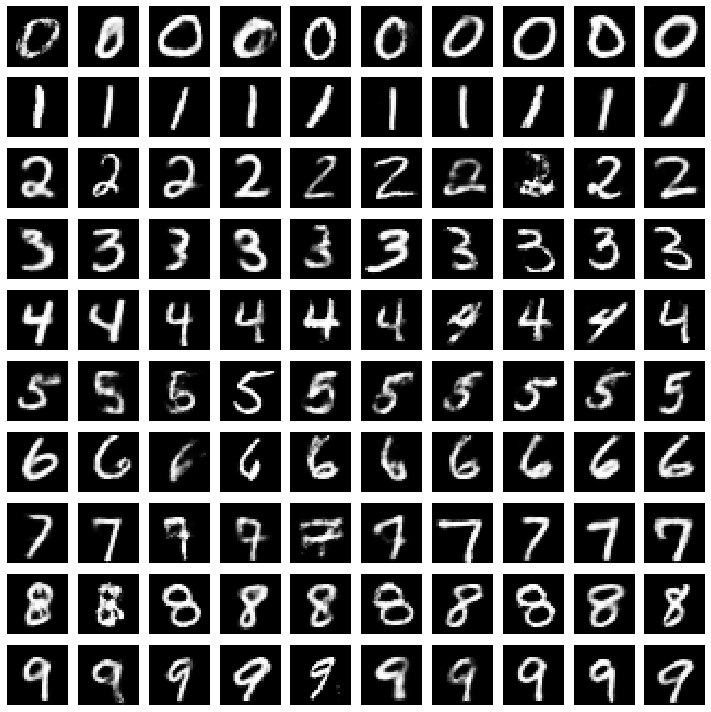

In [19]:
f, axarr = plt.subplots(10, 10, figsize=(10, 10))

samples = x_mu.cpu().data.view(-1, 28, 28).numpy()
# samples = x_mu.data.view(-1, 3, 32, 32).cpu().numpy().transpose(0, 2, 3, 1)


# mnist_means = np.tile(mnist_mean.reshape((1, -1)), (len(samples), 1))
# mnist_means[:, mnist_std > 0.1] = samples
# samples = mnist_means.reshape(-1, 28, 28)


for i, ax in enumerate(axarr.flat):
    ax.imshow(samples[i], cmap="gray")
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [21]:
# torch.save(model.state_dict(), "./adgm_mnist_new.ckpt")